In [1]:
from collections import defaultdict
from pathlib import Path

import colorcet as cc
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from dynamical_systems.analysis import lyapunov_gr
from dynamical_systems.analysis.jacobian import jacobian
from dynamical_systems.continuous import Lorenz96, solve_ode
from dynamical_systems.metrics import (
    cosine_similarity as cosine_similarity,
    maximum_mean_discrepancy as maximum_mean_discrepancy,
    mean_squared_error as mean_squared_error,
    sinkhorn_divergence as sinkhorn_divergence,
)
from dynamical_systems.transforms import TransformedODE
from dynamics_discovery.data import TimeSeriesDataset
from dynamics_discovery.io import load_model
from dynamics_discovery.metrics.error import relative_error_norm
from dynamics_discovery.models import NeuralODE
from matplotlib_utils.axes_setters import set_labels
from matplotlib_utils.plots import colored_scatterplot
from ott.utils import batched_vmap
from tqdm import tqdm


plt.style.use("matplotlib_utils.styles.dash_gridded")
jax.config.update("jax_default_device", jax.devices("gpu")[2])
jax.config.update("jax_enable_x64", True)


EXP_TYPES_ALL = (
    "vanilla",
    "jacobian",
    "tangent_evolution",
    "neighborhood",
    "normal",
    "proxy_tangent_evolution",
    "pca",
)
EXP_TYPES = (
    "vanilla",
    # "jacobian",
    # "tangent_evolution",
    # "proxy_tangent_evolution",
    "neighborhood",
    # "pca",
)

COLOR_DICT = dict(
    zip(
        EXP_TYPES_ALL,
        (
            "royalblue",
            "limegreen",
            "darkorange",
            "orangered",
            "saddlebrown",
            "purple",
            "purple",
        ),
    )
)
# LABEL_DICT = dict(
#     zip(
#         EXP_TYPES_ALL,
#         (
#             "Vanilla",
#             "Jacobian matching",
#             "Tangent Evolution matching",
#             "Neighborhood-based (ours)",
#             "Normal-based (ours)",
#             "Identity (ours)",
#         ),
#     )
# )
LABEL_DICT = dict(
    zip(
        EXP_TYPES_ALL,
        (
            "Conventional",
            "Jacobian matching",
            "Tangent Evolution matching",  # "Sobolev",
            "Neighborhood-based (ours)",
            "Normal-based (ours)",
            "Identity (ours)",
            "PCA (ours)",
        ),
    )
)

In [2]:
downsample = 2
noise = 0.0

datadir = Path("../../data")

dataset, transform = (
    TimeSeriesDataset(
        *TimeSeriesDataset.from_hdf5(datadir / "lorenz96_train.hdf5")[::100]
    )
    .downsample(downsample)
    .split_along_time(500)[0]
    .add_noise(noise)
    .standardize()
)
dataset_test = (
    TimeSeriesDataset(
        *TimeSeriesDataset.from_hdf5(datadir / "lorenz96_test.hdf5")[:100]
    )
    .downsample(downsample)
    .add_noise(0.0)
    .apply_transform(transform)
)

In [3]:
def load_experiment(
    exp_type: str,
    key: int,
    downsample: int,
    train_length: int,
    noise: float,
    rootdir=Path("../../results/smaller_datasets/50_500/lorenz96"),
) -> NeuralODE:
    loaddir = rootdir / f"downsample={downsample}/len={train_length}/{exp_type}"
    model_path_template = f"*lr=0.002_noise={noise}_key={key}*"
    if exp_type == "neighborhood":
        loaddir = loaddir / "r=0.85-1.13/neighbor_length=5"
        model_path_template = model_path_template + "_config"
    elif exp_type == "proxy_tangent_evolution":
        loaddir = loaddir / "weight=0.001"
    elif exp_type == "pca":
        loaddir = loaddir / "radius=2.0_rollout=1"

    model_paths = list(loaddir.glob(model_path_template))
    if len(model_paths) == 0:
        raise ValueError("No models found with the given conditions")
    elif len(model_paths) > 1:
        raise ValueError("Multiple models found with the given conditions!")
    else:
        return load_model(model_paths[0])


In [4]:
train_length = 5

In [13]:
key = 0
traj_idx = 10
t_traj, u_traj = dataset_test[traj_idx]

n_short = 450
t_short_norm = np.arange(n_short) * 0.02
t_short, u_short = t_traj[:n_short], u_traj[:n_short]

u_short_dict = defaultdict(list)
for exp_type in tqdm(EXP_TYPES):
    model = load_experiment(exp_type, key, downsample, train_length, noise)
    u_short_dict[exp_type] = solve_ode(model, t_short, u_short[0], rtol=1e-4, atol=1e-6)

100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Text(0.5, 0.98, 'Short term predictions: train_length=5, seed=0')

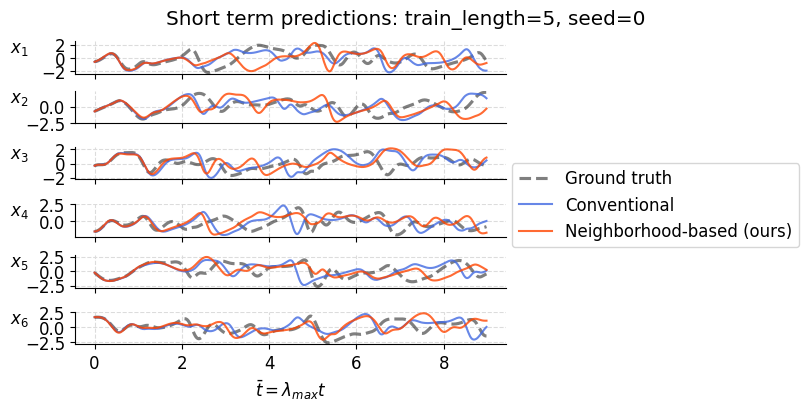

In [14]:
plot_kwargs = {"linewidth": 1.5, "alpha": 0.8}

fig, axes = plt.subplots(6, 1, figsize=(8, 4), sharex=True)
for i, (ax, y_name) in enumerate(zip(axes.flat, [f"$x_{i}$" for i in range(1, 7)])):
    ax.plot(
        t_short_norm,
        u_short[:, i],
        "--",
        color="black",
        linewidth=2.25,
        alpha=0.5,
        label="Ground truth",
    )
    for exp_type, u_pred in u_short_dict.items():
        ax.plot(
            t_short_norm,
            u_pred[:, i],
            color=COLOR_DICT[exp_type],
            label=LABEL_DICT[exp_type],
            **plot_kwargs,
        )
    ax.set_ylabel(y_name, rotation="horizontal")
ax.set_xlabel(r"$\bar{t}=\lambda_{max}t$")
fig.align_ylabels()
fig.legend(
    *ax.get_legend_handles_labels(), loc="outside center right", fontsize="medium"
)
fig.suptitle(f"Short term predictions: {train_length=}, seed={key}", fontsize="large")

In [15]:
from functools import partial

from dynamical_systems.metrics.statistical import (
    mean_spectral_hellinger_distance,
)
from jaxtyping import Array, Float


@eqx.filter_jit
def long_term_metrics(
    model, t_data: Float[Array, "batch time"], u_data: Float[Array, "batch time dim"]
):
    @partial(batched_vmap, batch_size=10)
    def _inner(t_, u_data_):
        u_pred_ = solve_ode(model, t_, u_data_[0], rtol=1e-4, atol=1e-6, max_steps=None)
        sinkhorn = sinkhorn_divergence(u_pred_, u_data_)
        hellinger = mean_spectral_hellinger_distance(u_pred_, u_data_)
        return {"sinkhorn": sinkhorn, "hellinger": hellinger}

    return _inner(t_data, u_data)

In [16]:
long_metrics_dict = defaultdict(list)
for exp_type in tqdm(EXP_TYPES):
    for key in (0, 10, 20):
        model = load_experiment(exp_type, key, downsample, train_length, noise)
        long_metrics_dict[exp_type].append(
            long_term_metrics(model, dataset_test.t, dataset_test.u)
        )

100%|██████████| 2/2 [05:31<00:00, 165.85s/it]


In [8]:
jax.tree.map(jnp.mean, long_metrics_dict)

NameError: name 'long_metrics_dict' is not defined

In [16]:
key = 0
jacobian_batch = eqx.filter_vmap(jacobian, in_axes=(None, None, 0))
jac_true = jacobian_batch(
    TransformedODE(Lorenz96(), transform), 0.0, dataset_test.u[:, 0]
)


@eqx.filter_jit
def compute_jac_err(model):
    jac_pred = jacobian_batch(model, 0.0, dataset_test.u[:, 0])
    return relative_error_norm(jac_pred, jac_true, axis=(-2, -1))


jac_logerr_dict = defaultdict(list)
for exp_type in tqdm(EXP_TYPES):
    jac_logerr_dict[exp_type] = np.log10(
        compute_jac_err(load_experiment(exp_type, key, downsample, train_length, noise))
    )

100%|██████████| 2/2 [00:00<00:00,  4.37it/s]


Text(0, 0.5, '$\\log_{10}||\\mathbf{J}_{true}-\\mathbf{J}_{pred}||_F\\;/\\;||\\mathbf{J}_{true}||_F$')

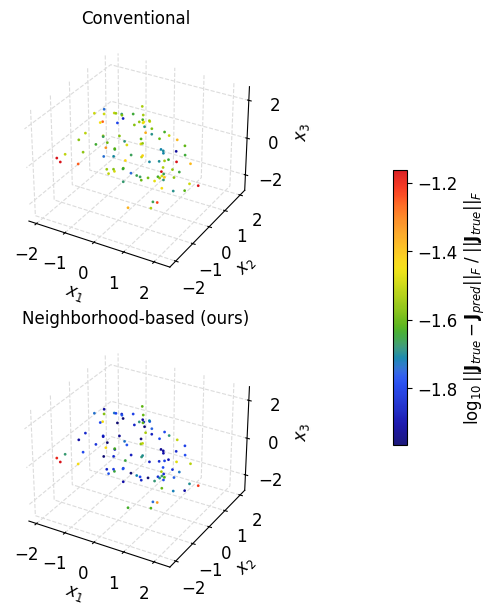

In [8]:
fig = colored_scatterplot(
    [dataset_test.u[:, 0, 0::2].T] * len(EXP_TYPES),
    [jac_logerr_dict[exp_type] for exp_type in EXP_TYPES],
    figsize=(10, 6),
    s=1,
    cmap=cc.cm.rainbow4,
    alpha=0.9,
    colorbar_shrink=0.5,
    horizontal=False,
)
for i, exp_type in enumerate(EXP_TYPES):
    fig.axes[i].set_title(LABEL_DICT[exp_type], fontsize="medium")
    set_labels(fig.axes[i], ["$x_1$", "$x_2$", "$x_3$"])
fig.axes[-1].set_ylabel(
    r"$\log_{10}||\mathbf{J}_{true}-\mathbf{J}_{pred}||_F\;/\;||\mathbf{J}_{true}||_F$"
)

In [ ]:
fig = colored_scatterplot(
    [dataset_test.u[:, 0, 1::2].T] * len(EXP_TYPES),
    [jac_logerr_dict[exp_type] for exp_type in EXP_TYPES],
    figsize=(10, 6),
    s=1,
    cmap=cc.cm.rainbow4,
    alpha=0.9,
)
for i, exp_type in enumerate(EXP_TYPES):
    fig.axes[i].set_title(LABEL_DICT[exp_type], fontsize="medium")
    set_labels(fig.axes[i], ["$x_4$", "$x_5$", "$x_6$"])
fig.axes[-1].set_ylabel(
    r"$\log_{10}||\mathbf{J}_{true}-\mathbf{J}_{pred}||_F\;/\;||\mathbf{J}_{true}||_F$"
)

NameError: name 'jac_logerr_dict' is not defined

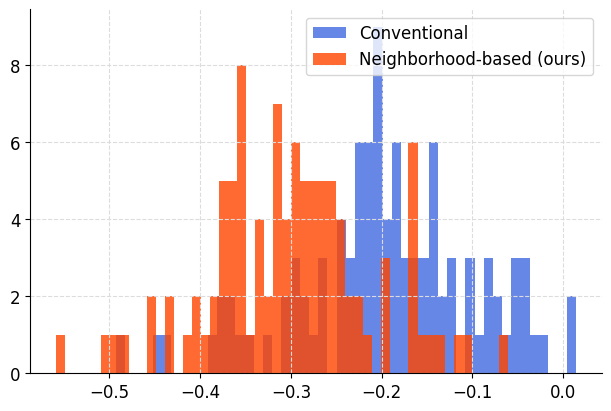

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for exp_type, log_err in jac_logerr_dict.items():
    ax.hist(
        log_err,
        bins=50,
        label=LABEL_DICT[exp_type],
        color=COLOR_DICT[exp_type],
        alpha=0.8,
    )
ax.legend()

In [5]:
ind_lya_max = 2500
lya_dict = jnp.load(datadir / "lorenz96_lyapunov_test.npz")


@eqx.filter_jit
def calculate_lyapunov(model):
    lyas = batched_vmap(
        lambda u0_: lyapunov_gr(
            model, u0_, lya_dict["t"][:ind_lya_max], rtol=1e-4, atol=1e-6, max_steps=64
        )[0],
        batch_size=5000,
    )(dataset_test.u[:, 0])
    return lyas

In [6]:
lyapunov_dict = defaultdict(list)

for exp_type in tqdm(EXP_TYPES):
    for k in (0, 10, 20):
        lyapunov_dict[exp_type].append(
            calculate_lyapunov(
                load_experiment(exp_type, k, downsample, train_length, noise)
            )
        )

100%|██████████| 2/2 [00:34<00:00, 17.50s/it]


In [7]:
jax.tree.map(lambda x: jnp.mean(x[:, -1], axis=0), lyapunov_dict)

defaultdict(list,
            {'neighborhood': [Array([ 1.23442828,  0.06094148, -0.15252001, -0.86587661, -1.63935855,
                     -4.61119896], dtype=float64),
              Array([ 1.26521392,  0.05790154, -0.1707402 , -0.85112518, -1.65565657,
                     -4.62103605], dtype=float64),
              Array([ 1.2104637 ,  0.05746928, -0.1397712 , -0.84697097, -1.63163623,
                     -4.65382662], dtype=float64)],
             'vanilla': [Array([ 1.25455146,  0.05999869, -0.14883968, -0.86514374, -1.6375007 ,
                     -4.66645201], dtype=float64),
              Array([ 1.26739009,  0.05249848, -0.15674369, -0.87731786, -1.63439752,
                     -4.65837041], dtype=float64),
              Array([ 1.21307792,  0.05346333, -0.13451079, -0.8432301 , -1.60796336,
                     -4.63251292], dtype=float64)]})

In [29]:
lya_known

array([ 1.249,  0.   , -0.098, -0.853, -1.629, -4.67 ])

Text(0.5, 0.98, 'Lyapunov spectrum: train length = 5, noise = 0.1')

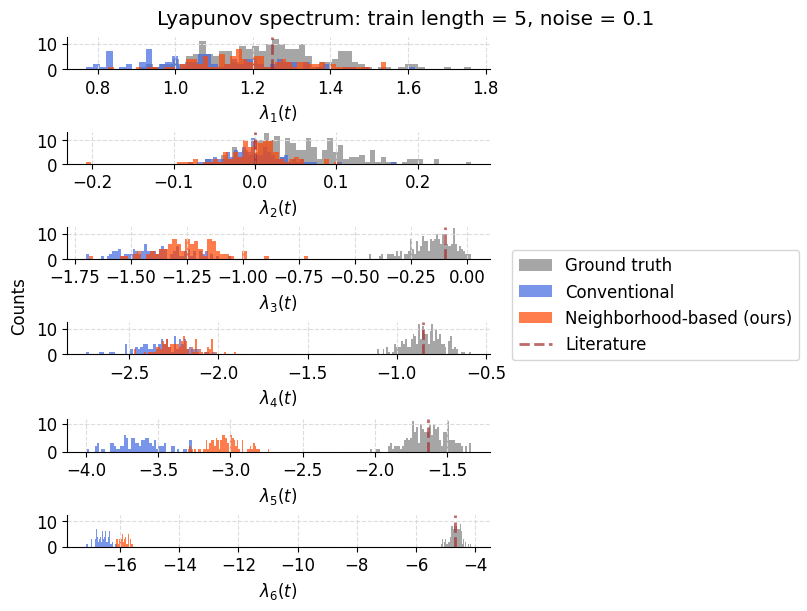

In [24]:
fig, axes = plt.subplots(6, 1, figsize=(8, 6))

hist_kwargs = {"bins": 50, "alpha": 0.7}
# ax.set_yscale("symlog", base=10)

lya_known = lya_dict["lyas_literature"]
lyas_true = lya_dict["lyas"][:, ind_lya_max - 1]
for i, ax in enumerate(axes.flat):
    ax.hist(
        lyas_true[::100, i],
        color="gray",
        label="Ground truth",
        **hist_kwargs,
    )
    for exp_type, v in lyapunov_dict.items():
        ax.hist(
            v[0][:, -1, i],
            color=COLOR_DICT[exp_type],
            label=LABEL_DICT[exp_type],
            **hist_kwargs,
        )

    ax.axvline(
        x=lya_known[i],
        color="brown",
        linewidth=2.0,
        linestyle="--",
        label="Literature",
        alpha=0.7,
    )
    ax.set_xlabel(rf"$\lambda_{i + 1}(t)$")

fig.legend(
    *axes[1].get_legend_handles_labels(), loc="outside center right", fontsize="medium"
)
fig.supylabel("Counts", fontsize="medium")
fig.align_ylabels()
fig.suptitle(f"Lyapunov spectrum: train length = {train_length}, noise = {noise}")

In [5]:
dataset_train_noiseless = (
    TimeSeriesDataset(
        *TimeSeriesDataset.from_hdf5(datadir / "lorenz96_train.hdf5")[::100]
    )
    .downsample(downsample)
    .split_along_time(500)[0]
)
transforms = [
    dataset_train_noiseless.add_noise(n).standardize()[1] for n in (0.0, 0.05, 0.1)
]

dataset_test_full = TimeSeriesDataset.from_hdf5(
    datadir / "lorenz96_test.hdf5"
).downsample(downsample)

100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


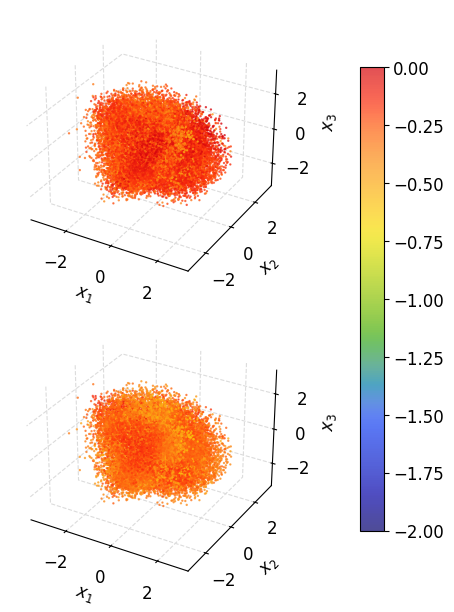

In [8]:
key = 0
noises = (0.0, 0.05, 0.1)
noise_idx = 2
jacobian_batch = eqx.filter_vmap(jacobian, in_axes=(None, None, 0))
u_ = dataset_test_full.apply_transform(transforms[noise_idx]).u[:, 0]
jac_true = jacobian_batch(TransformedODE(Lorenz96(), transforms[noise_idx]), 0.0, u_)


@eqx.filter_jit
def compute_jac_err(model):
    jac_pred = jacobian_batch(model, 0.0, u_)
    return relative_error_norm(jac_pred, jac_true, axis=(-2, -1))


jac_logerr_dict = defaultdict(list)
for exp_type in tqdm(EXP_TYPES):
    jac_logerr_dict[exp_type] = np.log10(
        compute_jac_err(
            load_experiment(exp_type, key, downsample, train_length, noises[noise_idx])
        )
    )

fig = colored_scatterplot(
    [u_[:, :3].T] * len(EXP_TYPES),
    [jac_logerr_dict[exp_type] for exp_type in EXP_TYPES],
    figsize=(9, 6),
    s=0.5,
    cmap=cc.cm.rainbow4,
    alpha=0.7,
    colorbar_pad=0.07,
    colorbar_shrink=0.8,
    horizontal=False,
    vmin=-2.0,
    vmax=0.0,
    vmin_percentile=None,
    vmax_percentile=None,
)
for i, exp_type in enumerate(EXP_TYPES):
    # fig.axes[i].set_title(LABEL_DICT[exp_type], fontsize="medium")
    set_labels(fig.axes[i], ["$x_1$", "$x_2$", "$x_3$"])
# fig.axes[-1].set_ylabel(
#     r"$\log_{10}||\mathbf{J}_{true}-\mathbf{J}_{pred}||_F\;/\;||\mathbf{J}_{true}||_F$"
# )